## Swin Base

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


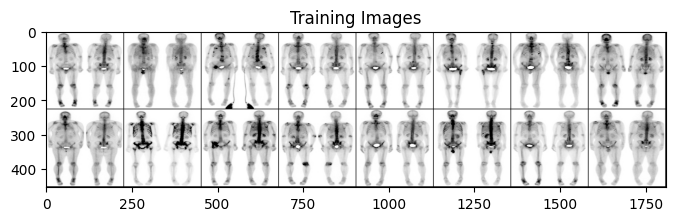

Labels: tensor([0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0])
Epoch [1/4], Train Loss: 0.4479735051598219, Test Loss: 0.6861071214079857, Test AUC: 0.8509
Epoch [2/4], Train Loss: 0.1686786348079286, Test Loss: 0.9295407332945615, Test AUC: 0.9113
Epoch [3/4], Train Loss: 0.05847432312018179, Test Loss: 0.7075681895017624, Test AUC: 0.9152
Epoch [4/4], Train Loss: 0.025826381172627963, Test Loss: 1.2982106225419556, Test AUC: 0.9272


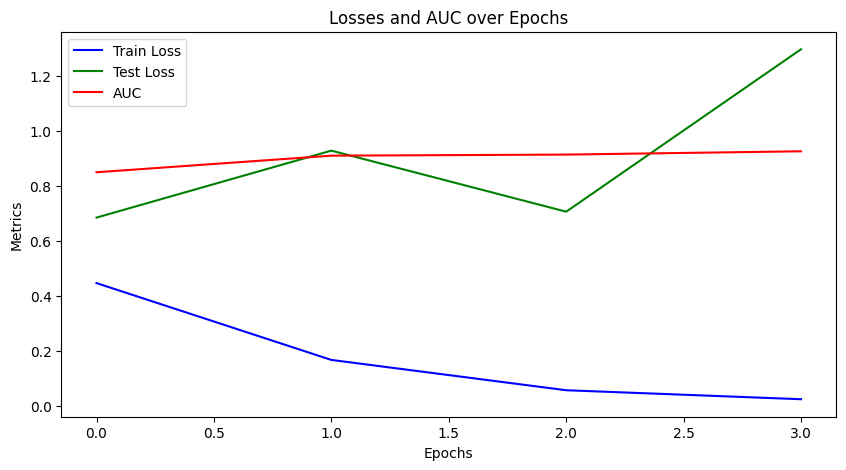

Accuracy: 0.8375
Sensitivity: 0.6875
Specificity: 0.9875
PPV: 0.9821428571428571
NPV: 0.7596153846153846
AUC: 0.9271874999999999
Precision: 0.9821428571428571
Recall: 0.6875
F1-score: 0.8088235294117647
Loss: 1.2982106225419556


In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import swin_b, Swin_B_Weights
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 4
num_classes = 2
batch_size = 16
learning_rate = 0.0001

# Utility Functions
def preproc_image(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    preprocessing = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
    return preprocessing(img.copy()).unsqueeze(0)

def calculate_probabilities(outputs):
    return torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()

def evaluate_model(model, loader, device, criterion):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    losses = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            losses.append(criterion(outputs, labels).item())
            probs = calculate_probabilities(outputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy().tolist())
            all_preds.extend(predicted.cpu().numpy().tolist())
            all_probs.extend(probs.tolist())

    accuracy = np.mean(np.array(all_labels) == np.array(all_preds))
    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()
    metrics = {
        'Accuracy': accuracy,
        'Sensitivity': tp / (tp + fn),
        'Specificity': tn / (tn + fp),
        'PPV': tp / (tp + fp),
        'NPV': tn / (tn + fn),
        'AUC': roc_auc_score(all_labels, all_probs),
        'Precision': precision_score(all_labels, all_preds),
        'Recall': recall_score(all_labels, all_preds),
        'F1-score': f1_score(all_labels, all_preds),
        'Loss': np.mean(losses)
    }
    return metrics, all_probs, all_labels

# Data Preparation
data_dir = 'D:/Bone_scan/preprocessing_comparison/segmented_cropped/set1/'
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
test_transform = train_transform

train_dataset = ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'test'), transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model Initialization
model = swin_b(weights=Swin_B_Weights.DEFAULT)
model.head = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.head.in_features, num_classes)
)

# Make all layers trainable
for param in model.parameters():
    param.requires_grad = True

# Move model to GPU
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)

# Training Loop
train_loss_over_epochs, test_loss_over_epochs, test_auc_over_epochs = [], [], []

for epoch in range(num_epochs):
    model.train()
    train_losses = []

    for i, (images, labels) in enumerate(train_loader):
        # Visualize some training data (only in the first epoch and first batch)
        if epoch == 0 and i == 0:
            plt.figure(figsize=(8, 8))
            out = torchvision.utils.make_grid(images)
            plt.imshow(np.transpose(out.numpy(), (1, 2, 0)))
            plt.title("Training Images")
            plt.show()
            print("Labels:", labels)

        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())
            
    metrics, probs, labels = evaluate_model(model, test_loader, device, criterion)
    test_auc_over_epochs.append(metrics['AUC'])

    train_loss_over_epochs.append(np.mean(train_losses))
    test_loss_over_epochs.append(np.mean(val_losses))

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {np.mean(train_losses)}, Test Loss: {np.mean(val_losses)}, Test AUC: {metrics['AUC']:.4f}")

    if (epoch + 1) % 10 == 0:
        for key, value in metrics.items():
            print(f"{key}: {value}")

    scheduler.step()

# Plotting Results
plt.figure(figsize=(10, 5))
plt.plot(train_loss_over_epochs, label='Train Loss', color='blue')
plt.plot(test_loss_over_epochs, label='Test Loss', color='green')
plt.plot(test_auc_over_epochs, label='AUC', color='red')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Losses and AUC over Epochs')
plt.legend()
plt.show()

# Final evaluation and model saving
final_metrics, final_probs, final_labels = evaluate_model(model, test_loader, device, criterion)
for key, value in final_metrics.items():
    print(f"{key}: {value}")

torch.save(model.state_dict(), "my_model_swin_b_set1_e4.pth")

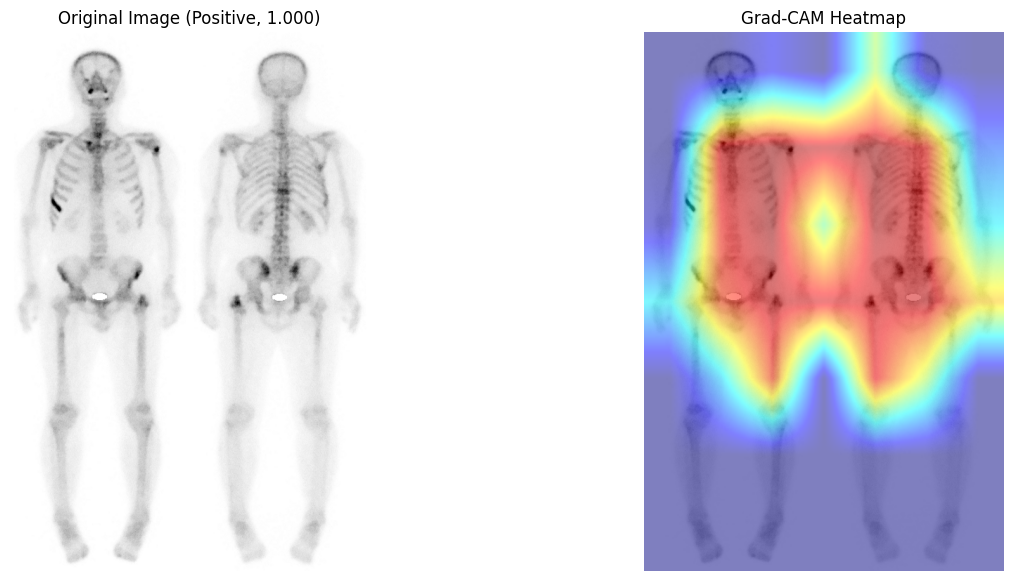

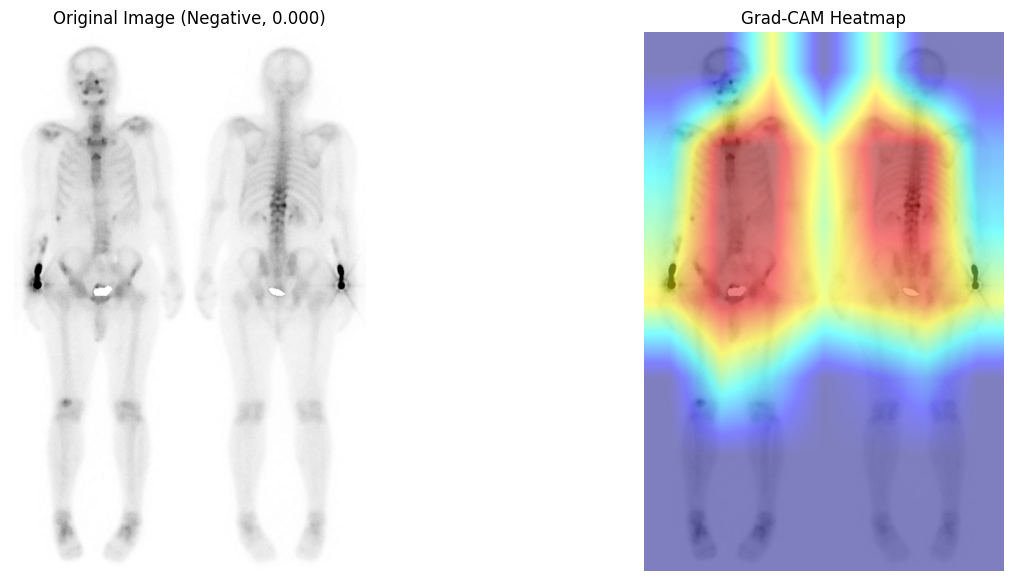

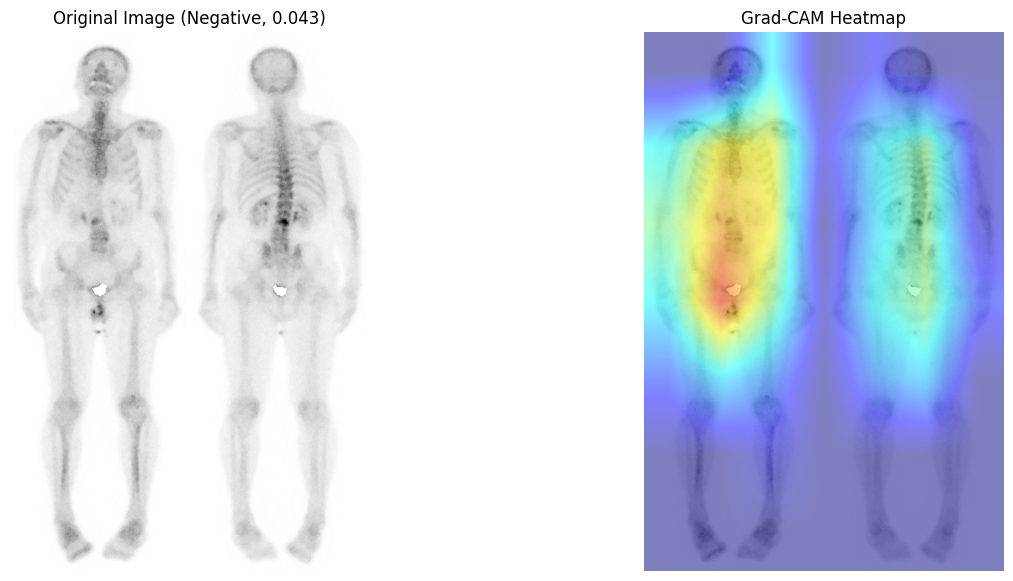

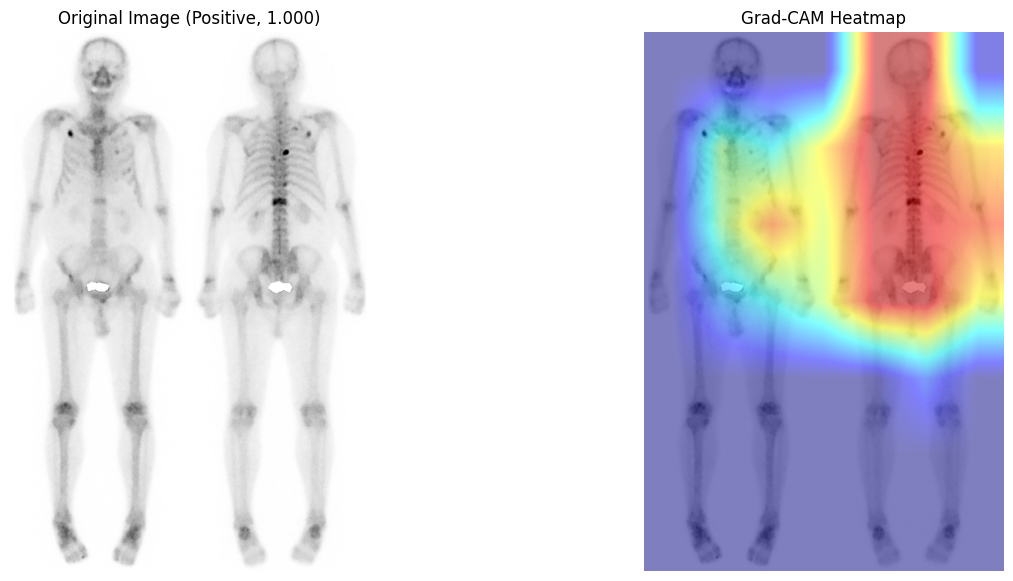

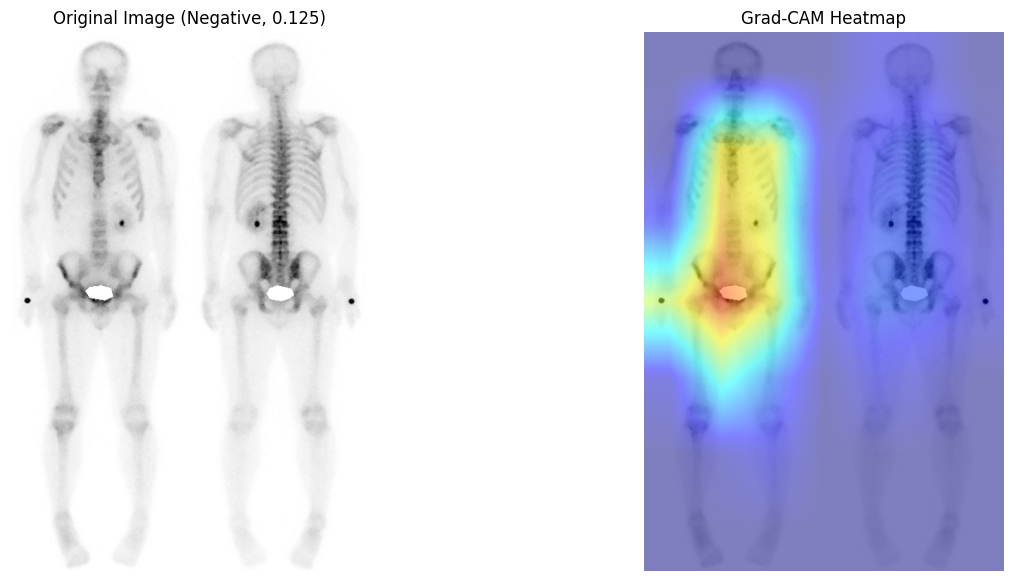

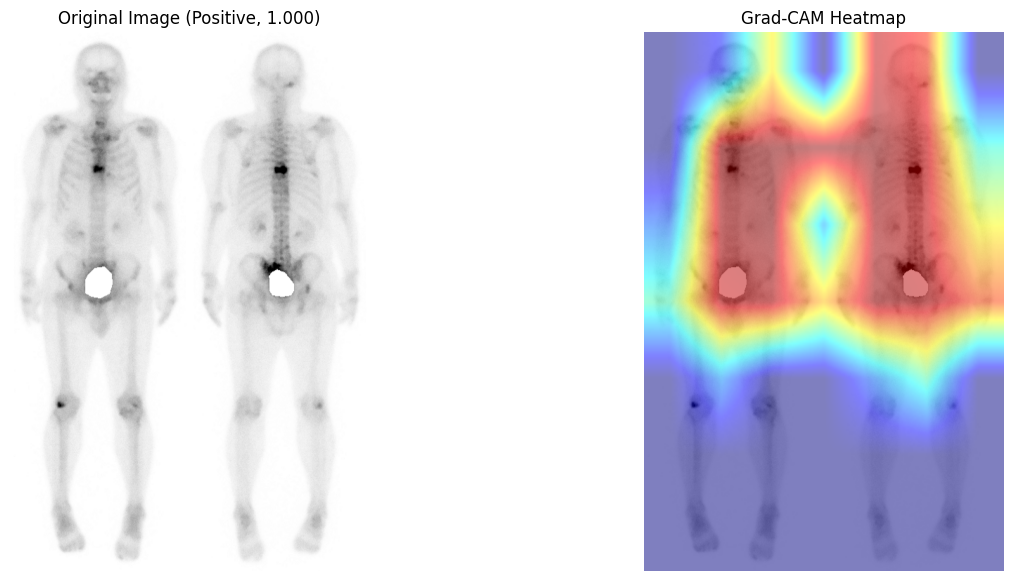

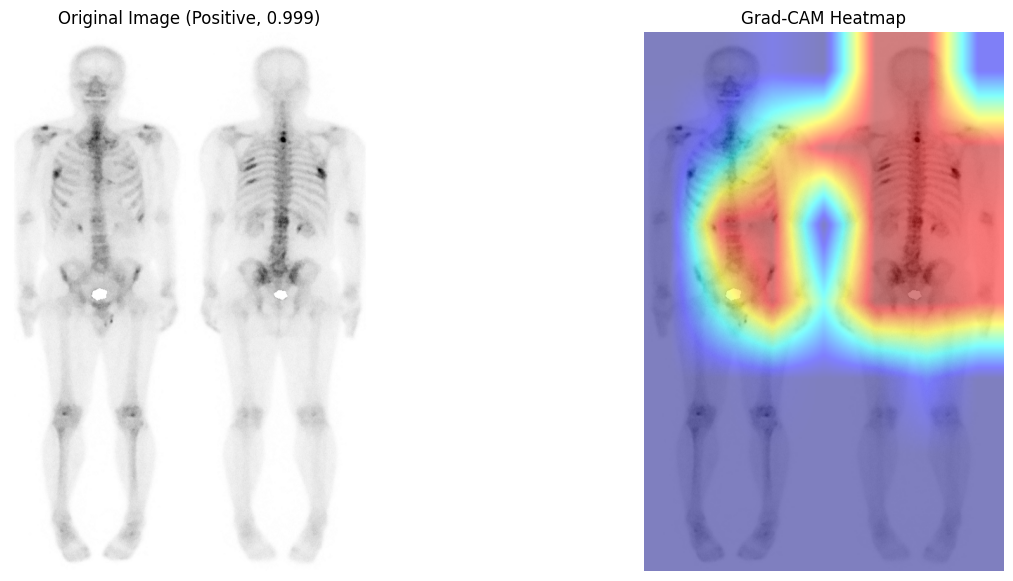

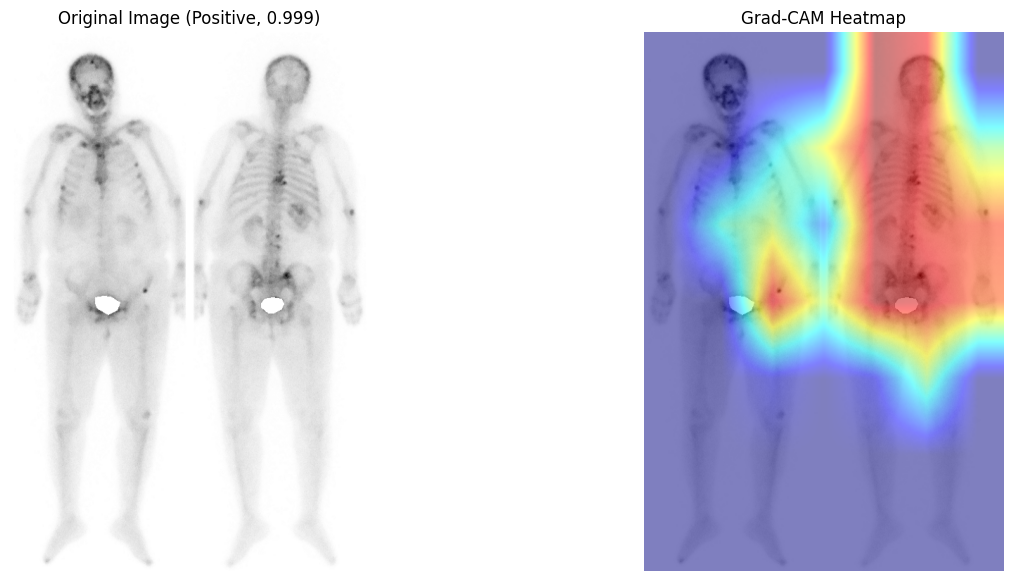

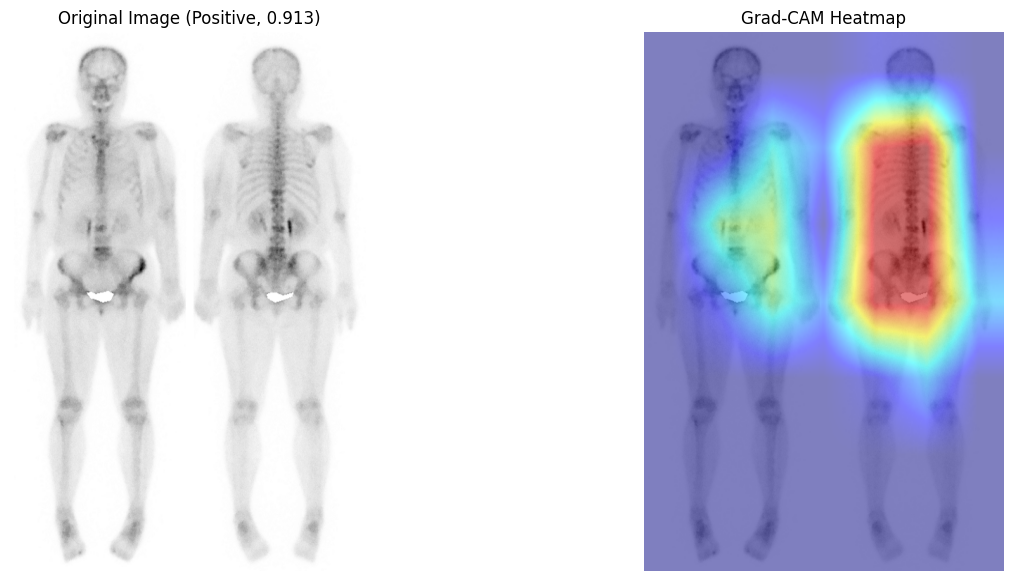

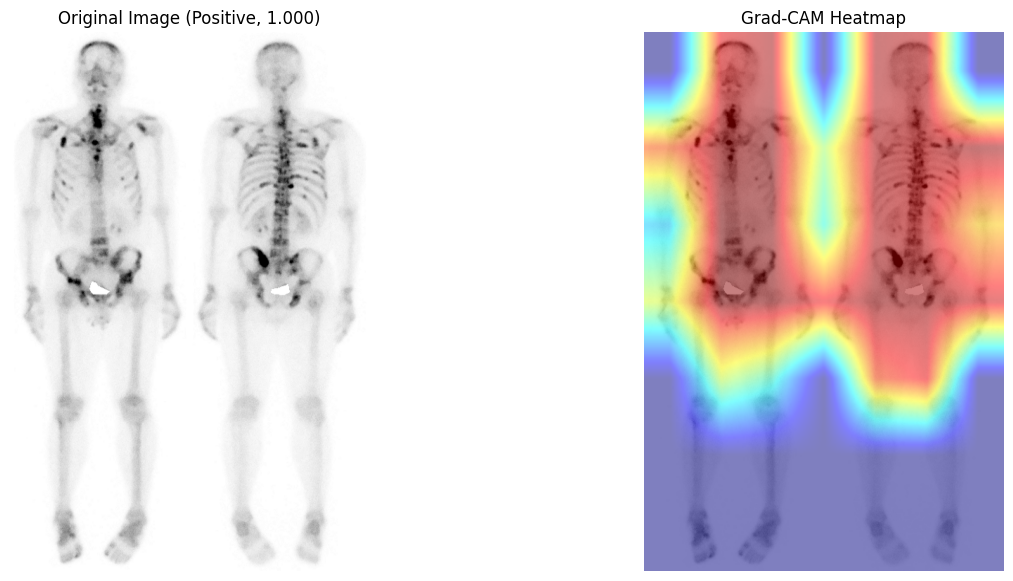

In [4]:
import os
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision import models
from torchvision.models import swin_b, Swin_B_Weights
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

# Utility Functions
def reshape_transform(tensor, height=7, width=7):
    result = tensor.reshape(tensor.size(0), height, width, tensor.size(3))
    return result.transpose(2, 3).transpose(1, 2)

# Load the trained model
def load_trained_model(model_path):
    model = swin_b(weights=Swin_B_Weights.DEFAULT)
    model.head = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(model.head.in_features, num_classes)
    )
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

# Apply Grad-CAM
def apply_grad_cam_and_classify(image_path, model, target_layer, transform, output_folder):
    img = Image.open(image_path).convert("RGB")
    original_size = img.size

    img_transformed = transform(img).unsqueeze(0).to(device)

    # Prediction and softmax probabilities
    with torch.no_grad():
        output = model(img_transformed)
        prob = torch.softmax(output, dim=1)[0][1].item()
        predicted_class = output.argmax(dim=1).item()

    cam = GradCAM(model=model, target_layers=[target_layer], reshape_transform=reshape_transform)
    grayscale_cam = cam(input_tensor=img_transformed, eigen_smooth=True, aug_smooth=True)[0]

    heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, original_size, interpolation=cv2.INTER_LINEAR)

    img_np = np.array(img)
    superimposed_img = heatmap * 0.5 + img_np * 0.5

    label = "Positive" if predicted_class == 1 else "Negative"
    if label == "Positive":
        global num_positives
        num_positives += 1

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    filename = os.path.splitext(os.path.basename(image_path))[0]
    plt.imsave(os.path.join(output_folder, f"{filename}_{label}.png"), superimposed_img.astype('uint8'))

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title(f"Original Image ({label}, {prob:.3f})")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img.astype('uint8'))
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')
    plt.show()

# Global variable to count positives
num_positives = 0

# Setup and execution
test_images_dir = 'D:/Bone_scan/preprocessing_comparison/segmented_cropped/set1/test/positive'
output_folder = 'D:/Bone_scan/preprocessing_comparison/segmented_cropped/set1/heatmap_swin_positive'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 2
model_path = "my_model_swin_b_set1_e4.pth"
model = load_trained_model(model_path)
target_layer = model.features[-1][-1].norm1

# Limit the processing to the first 10 images
image_paths = os.listdir(test_images_dir)[:10]
for image_path in image_paths:
    full_image_path = os.path.join(test_images_dir, image_path)
    apply_grad_cam_and_classify(full_image_path, model, target_layer, transform, output_folder)

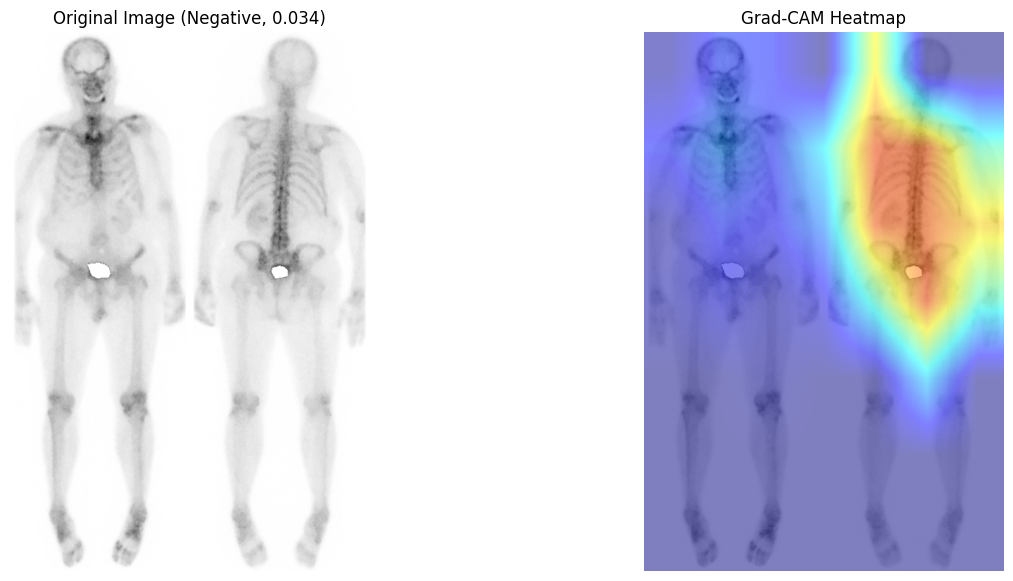

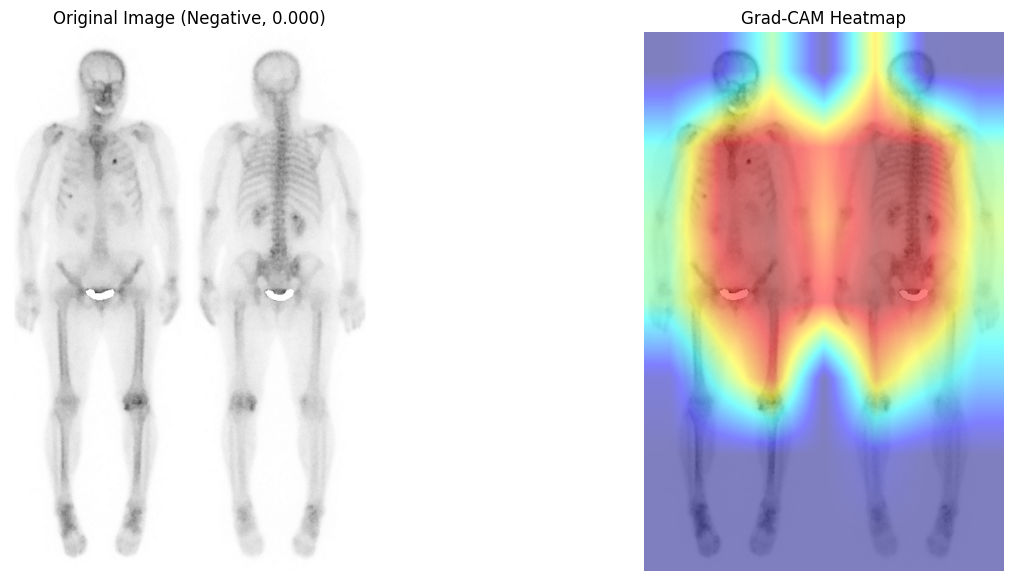

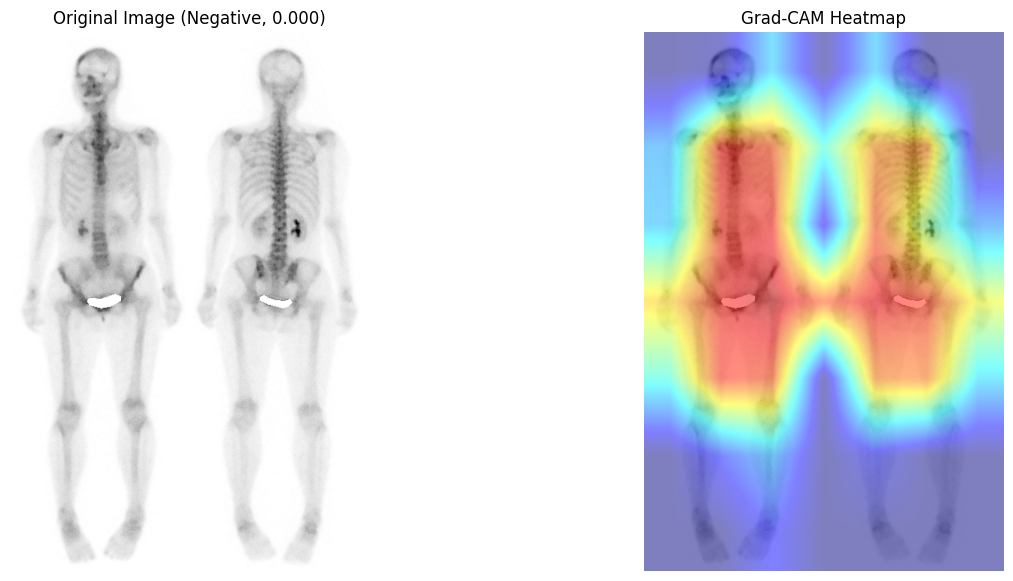

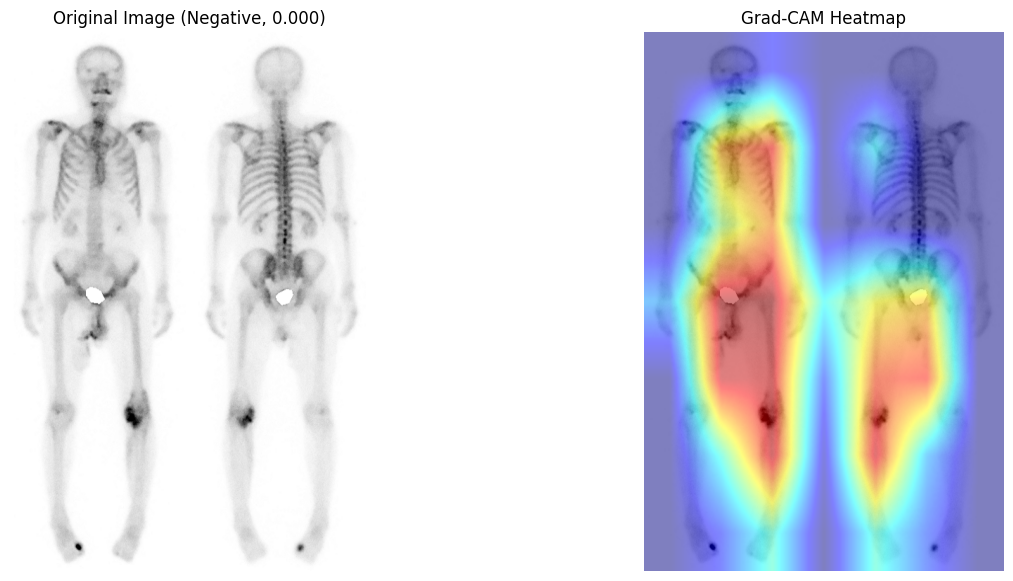

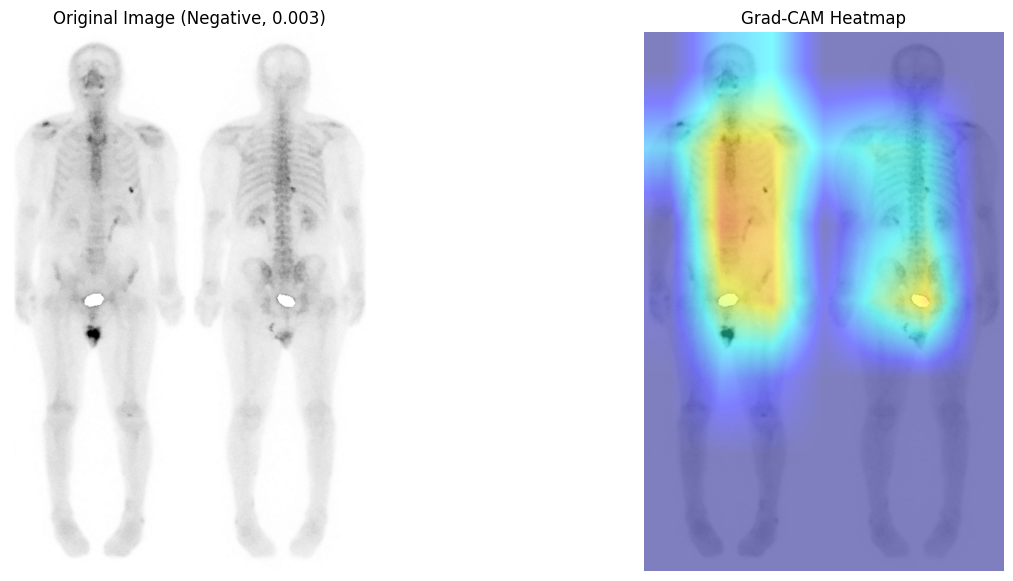

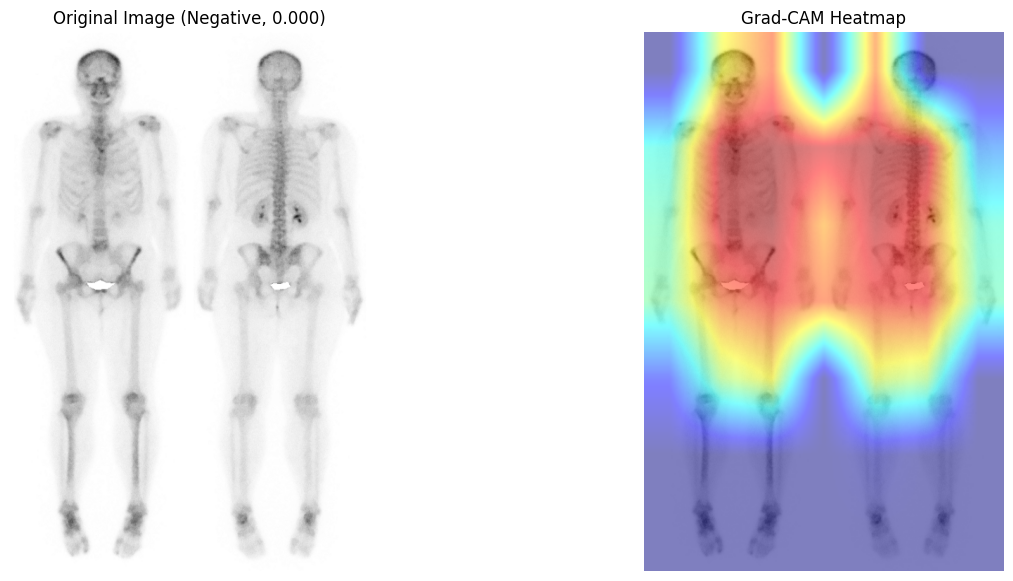

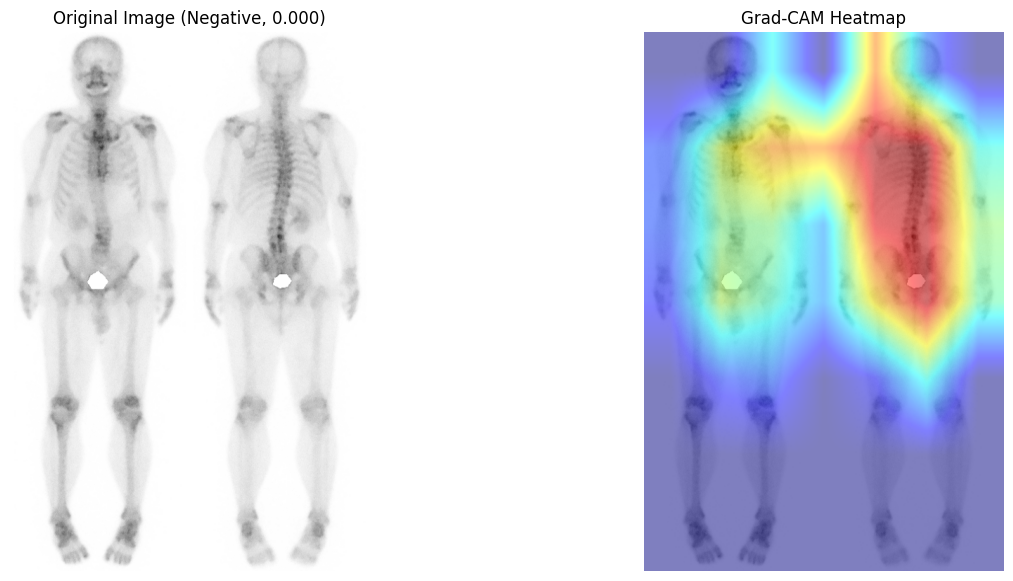

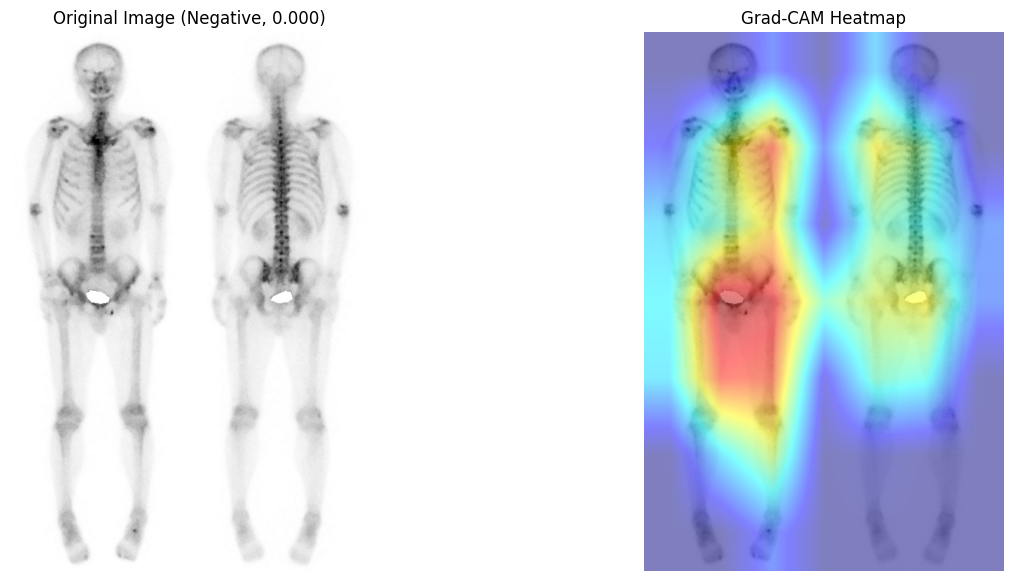

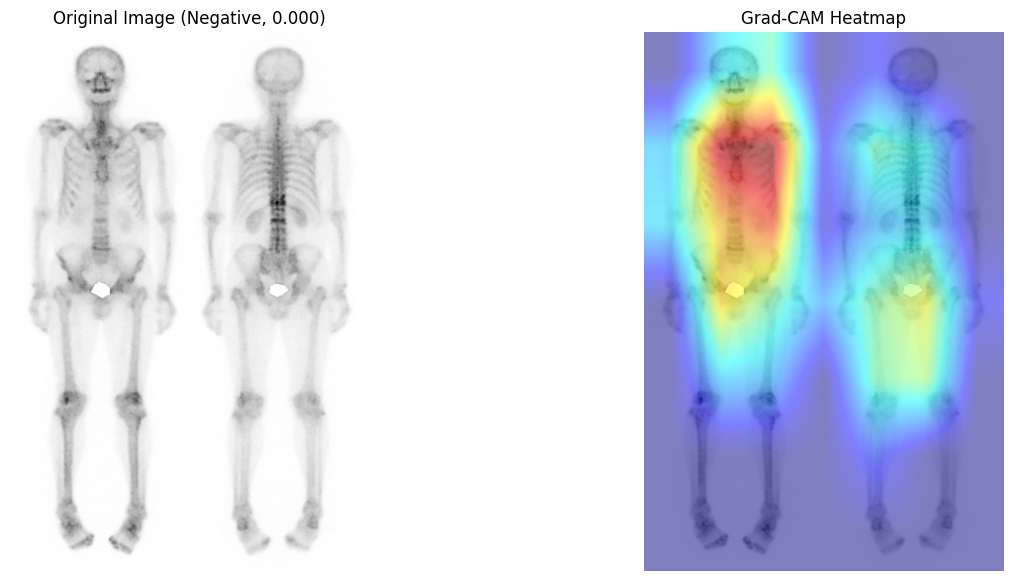

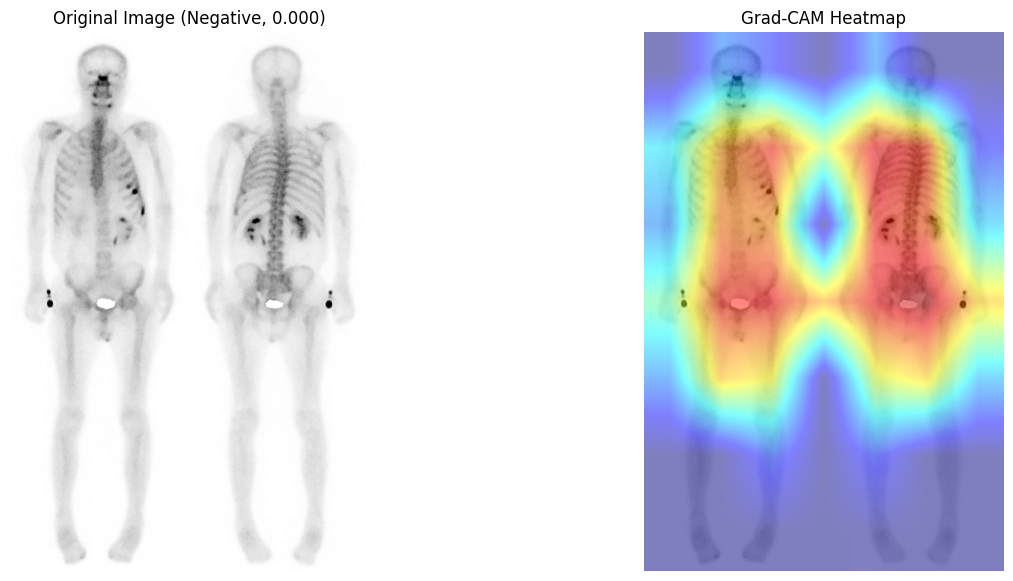

In [6]:
import os
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision import models
from torchvision.models import swin_b, Swin_B_Weights
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

# Utility Functions
def reshape_transform(tensor, height=7, width=7):
    result = tensor.reshape(tensor.size(0), height, width, tensor.size(3))
    return result.transpose(2, 3).transpose(1, 2)

# Load the trained model
def load_trained_model(model_path):
    model = swin_b(weights=Swin_B_Weights.DEFAULT)
    model.head = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(model.head.in_features, num_classes)
    )
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

# Apply Grad-CAM
def apply_grad_cam_and_classify(image_path, model, target_layer, transform, output_folder):
    img = Image.open(image_path).convert("RGB")
    original_size = img.size

    img_transformed = transform(img).unsqueeze(0).to(device)

    # Prediction and softmax probabilities
    with torch.no_grad():
        output = model(img_transformed)
        prob = torch.softmax(output, dim=1)[0][1].item()
        predicted_class = output.argmax(dim=1).item()

    cam = GradCAM(model=model, target_layers=[target_layer], reshape_transform=reshape_transform)
    grayscale_cam = cam(input_tensor=img_transformed, eigen_smooth=True, aug_smooth=True)[0]

    heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, original_size, interpolation=cv2.INTER_LINEAR)

    img_np = np.array(img)
    superimposed_img = heatmap * 0.5 + img_np * 0.5

    label = "Positive" if predicted_class == 1 else "Negative"
    if label == "Positive":
        global num_positives
        num_positives += 1

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    filename = os.path.splitext(os.path.basename(image_path))[0]
    plt.imsave(os.path.join(output_folder, f"{filename}_{label}.png"), superimposed_img.astype('uint8'))

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title(f"Original Image ({label}, {prob:.3f})")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img.astype('uint8'))
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')
    plt.show()

# Global variable to count positives
num_positives = 0

# Setup and execution
test_images_dir = 'D:/Bone_scan/preprocessing_comparison/segmented_cropped/set1/test/negative'
output_folder = 'D:/Bone_scan/preprocessing_comparison/segmented_cropped/set1/heatmap_swin_negative'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 2
model_path = "my_model_swin_b_set1_e4.pth"
model = load_trained_model(model_path)
target_layer = model.features[-1][-1].norm1

# Limit the processing to the first 10 images
image_paths = os.listdir(test_images_dir)[:10]
for image_path in image_paths:
    full_image_path = os.path.join(test_images_dir, image_path)
    apply_grad_cam_and_classify(full_image_path, model, target_layer, transform, output_folder)